# Инструкции
В этом д/з две части про манипуляции с learning rate и циклом обучения.
1. Cyclical learning rate 
2. Snapshot ensembles

Можете выполнить только одно из двух, чтобы сдать д/з. Или оба, если хотите и есть возможность. Сдавать их можно так же, как и прошлое д/з.

# Cyclical learning rate callback

Подробнее можно почитать в этой статье: [Cyclical Learning Rates for Training Neural Networks
](https://arxiv.org/abs/1506.01186).

Основная цель - реализовать циклический learing rate для своих моделей в виде коллбэка. 

Циклический lr нужен для ускорения обучения моделей. Топология функции ошибки для нейросетей может содержать *много* седловых точек, и во время обучения нейросеть склонна "застревать" в них, пока она сходится к локальному минимуму. Это замедляет обучение. Почему седловые точки плохи? Градиент в них близок к нулю (т.е. параметры почти не будут обновляться). И SGD может надолго застрять в такой точке. Она не является стабильной (в том смысле, что маленькое отлколенение выведет модель из седловой точки), но из-за небольших градиентов модель выходит из такой точки медленнее, чем хотелось бы.

В дмумерном случае седловые точки довольно просты, но все еще могут создать серьезные проблемы для оптимизации (а некоторый алгоритмы и вовсе "сломать", хотя это не относится к SGD). В многомерном случае они могут быть гораздо более сложно устроены, а главное, случайно "попасть" в такую точку гораздо проще.






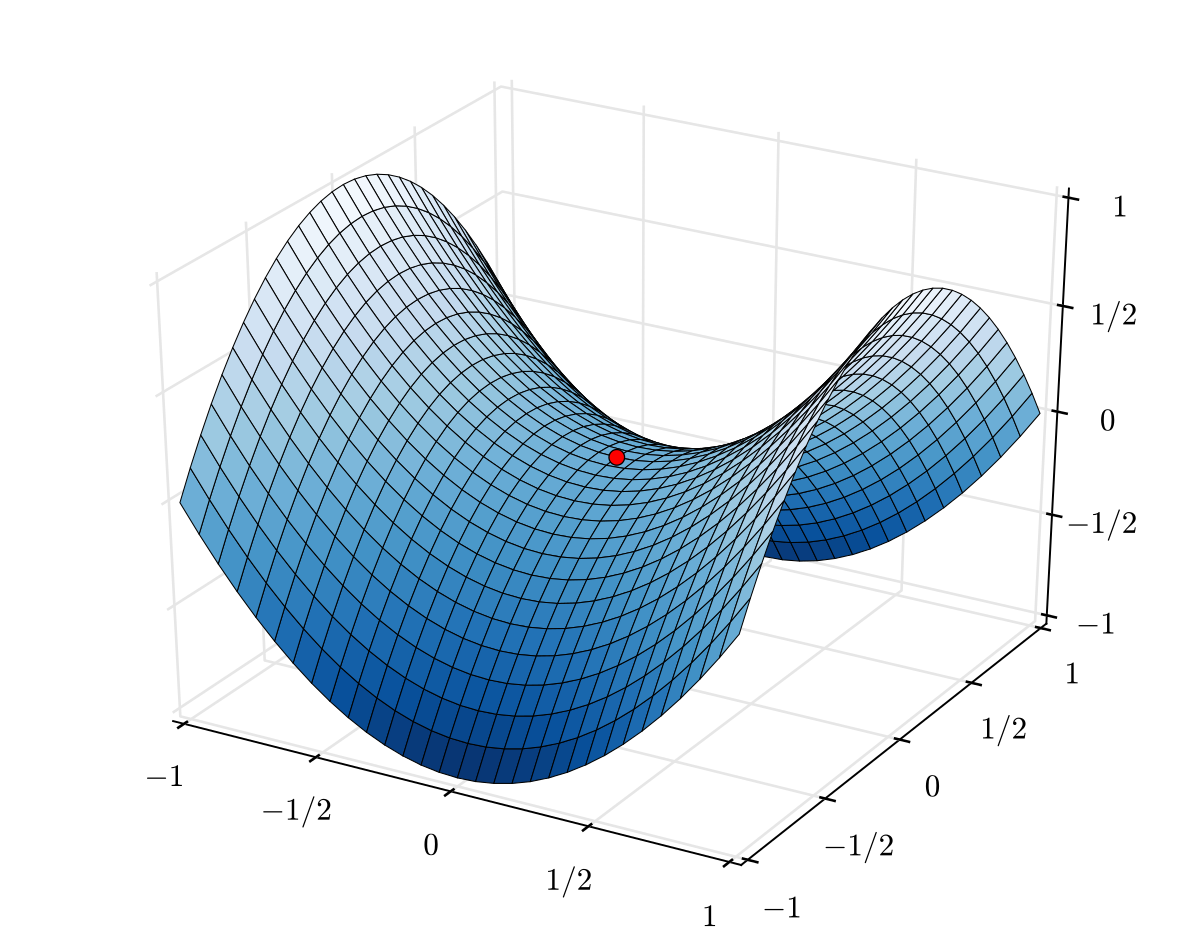








Циклический lr призван "помочь" нейросети быстрее выходить из седловых точек, так как придает дополнительное "ускорение" сети, пока она сидит в седловой точке. 

Важно, что этот метод *никак* не проверяет, является ли та точка, где нейростеть находится в данный момент, седловой или окрестностями сделовой тотчки. Тем не менее, он может быть эффективен.

График изменения lr в зависимости от количества итераций (батчей) на картинке ниже:

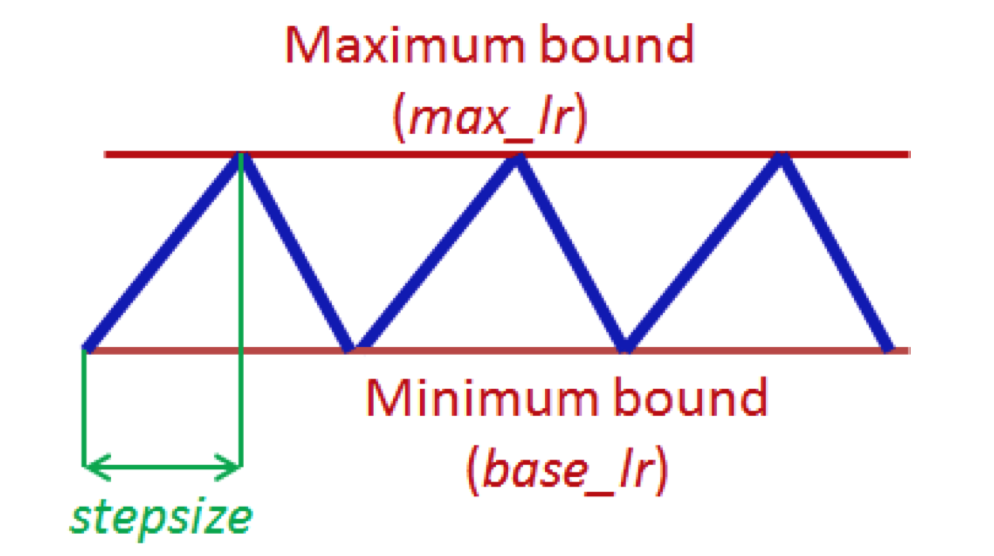


`stepsize` в данном случае - это количество батчей, в течение которых lr повышается; 

В упомянутой выше статье используются три способа задания lr - triangular (на кратинке выше), амплитуда lr не меняется от цикла к цилку; triangular2 - амплитуда уменьшается в два раза с каждым циклом; и exponential - используется экспоненциельное задухагие амплитуды с параметром $gamma < 1$ по формуле $lr \cdot gamma^{(n.\ of\ cycle\ iterations)}$

В `tf.keras` такое "вмешательство" в цикл обучения проще всего реализовать с помощью коллбэка. 

В д/з достаточно будет сделать самую простую trinagular policy. Если хотите, можете реализовать и остальные варианты.

Обратите внимание, что коллбеки **не являются** частью модели, передаются в метод fit и не сохраняются с ней. Реализовывать `get_config` не нужно.

# Задание 1:
* Реализуйте `CyclicLR`. Подробнее - в шаблоне класса ниже.
* Сравните, как обучаются нейронные сети с одинаковой архитектурой с `CyclicLR` и без него. Постройте графики. 
* Используйте датасет `fashion_mnist`, архитектуру сети выберите самостоятельно. Можно провести несколько экспериментов с разными вариантами архитектур.

## Шаблон CyclicLR

In [128]:
%load_ext tensorboard
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
from tensorflow import keras
import tensorflow.keras.layers as layers
import numpy as np
import os
import datetime

import matplotlib.pyplot as plt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [113]:
class CyclicLR(Callback):
    """ Коллбек, реализующий циклический lr.
    
    # Пример
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000)
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Можно использовать собственные функции для задания lr:
        ```python
            clr_fn = lambda x: 0.5 * (1 + np.sin(x * np.pi / 2.))
            clr = CyclicLR(
              base_lr=0.001, max_lr=0.006, step_size=2000, scale_fn=clr_fn)
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: базовый lr, значение в нижней точке цикла.
        max_lr: верхнее значение lr. Определяет амлитуду цикла 
            (max_lr - base_lr). Значение lr в любом цикле - это сумма base_lr 
            и значения амплитуды, умноженного на некторое значение. Значение 
            max_lr может не достигаться, если испозуется policy, уменьшающая lr 
            на каждом следующейм цикле (triangular2, exponential)
        step_size: количество обучающих итераций в каждом цикле. Рекомендовано 
            брать как (количество итераций в эпохе) * (значение [2-8])
        scale_fn: Функция для скейлинга lr, которая должна возвращать значения
            в диапазоне 0 <= scale_fn(x) <= 1 для всех x >= 0.
    """

    def __init__(self, base_lr=0.001,
                 max_lr=0.006, 
                 step_size=2000,
                 scale_fn=None):
        super(CyclicLR, self).__init__()
        self.scale_fn = scale_fn or (lambda x: 1)
        self.clr_iterations = 0
        self.history = {}
        # Задайте далее все нужные параметры 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        
    def clr(self):
        """ Внутри этого метода реализуйте вычисление значения lr. В случае с
        triangular policy в течение stepsize итераций значения lr должны 
        линейно расти, а затем в течение еще stepsize итераций - снижаться. 
        При этом базовое значение амлитдуы умножается значение scale_fn (это
        может быть нужно для того, чтобы изменить график изменения lr, например, 
        на синусоидальный или другой, см. пример в описании класса)
        """
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        clr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * \
                             self.scale_fn(cycle)  # как вариант - self.clr_iterations
        return clr
        
    def on_train_begin(self, logs={}):
        logs = logs or {}
        """ Инициализируйте значение lr оптимизатора значением base_lr, если
        это начало обучения (clr_iterations == 0), иначе восстановите 
        предыдущее значение lr.

        Для задания lr используйте функцию keras.backend set_value:

        import tensorflow.keras.backend as K
        K.set_value(self.model.optimizer.learning_rate, lr)

        self.model - модель, в метод fit которой передан callback.
        """
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.history["clr"][-1])
        
    def on_batch_end(self, batch, logs=None):
        """
        После каждого батча нужно:
        1. Обновить значения количества итераций обучения
        2. Инкрементировать количество итераций циклического lr:
         self.clr_iterations
        3. Обновить логи (лучше желательно туда значение lr). Получить значение 
          тензора в графе можно методом K.get_value(tensor), например, 
          K.get_value(self.model.optimizer.learning_rate)
        4. Выставить новое значение lr методами K.set_value и self.clr()
        """
        logs = logs or {}
        # записываем текущее состояние
        logs["clr"] = K.get_value(self.model.optimizer.learning_rate)
        self.history.setdefault('clr', []).append(logs["clr"])
        # готовим новый цикл
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        

#### тестируем метод-функцию для clr()

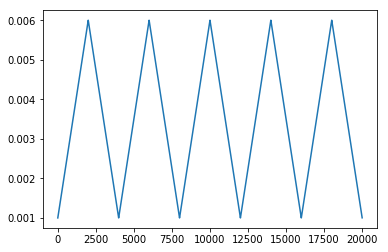

In [153]:
clr_cb = CyclicLR()
clr_cb.clr_iterations = np.arange(20_000)
plt.plot(clr_cb.clr());

не единичная **scale_fn**

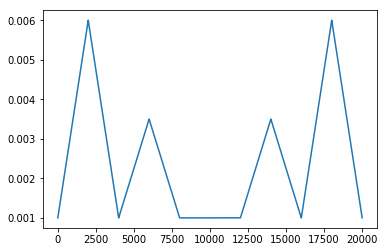

In [87]:
clr_fn = lambda x: 0.5 * (1 + np.sin(x * np.pi / 2.))

clr_cb = CyclicLR(scale_fn=clr_fn)
clr_cb.clr_iterations = np.arange(20_000)
plt.plot(clr_cb.clr());

## Обучение моделей

In [88]:
def make_model(n_classes=10):
    # Функция для создания модели
    activation = 'tanh'
    units = 256
    model = keras.Sequential([
        layers.Dense(units, activation=activation),
        layers.Dense(units, activation=activation),
        layers.Dense(n_classes, activation='softmax')])
    return model

In [89]:
from tensorflow.keras.datasets import fashion_mnist

In [90]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# Добавьте предобработку, аналогичную обработке MNIST
x_train = (x_train.reshape(x_train.shape[0], -1).astype("float32") / 255.0 - 0.5) * 2
x_test = (x_test.reshape(x_test.shape[0], -1).astype("float32") / 255.0 - 0.5) * 2

x_train.shape, x_test.shape

((60000, 784), (10000, 784))

## Обучите модели и постойте графики

#### тестируем

In [135]:
# %tensorboard --logdir logs

In [126]:
model = make_model(10)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'],
              loss='sparse_categorical_crossentropy')

In [129]:
clr_cb = CyclicLR(base_lr=0.01,
                  max_lr=0.06, 
                  step_size=2000)

# logdir = os.path.join("logs", "clr",
#                       datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

epochs = 10
batch_size = 128
history = model.fit(x_train, y_train, 
                      validation_data=(x_test, y_test),
                      epochs=epochs,
                      batch_size=batch_size,
                      callbacks=[clr_cb])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 35us/sample - loss: 0.7386 - accuracy: 0.7556 - val_loss: 0.5513 - val_accuracy: 0.8032
Epoch 2/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.4775 - accuracy: 0.8309 - val_loss: 0.4707 - val_accuracy: 0.8327
Epoch 3/10
60000/60000 [==============================] - 2s 29us/sample - loss: 0.4273 - accuracy: 0.8482 - val_loss: 0.4478 - val_accuracy: 0.8370
Epoch 4/10
60000/60000 [==============================] - 2s 27us/sample - loss: 0.4025 - accuracy: 0.8551 - val_loss: 0.4224 - val_accuracy: 0.8487
Epoch 5/10
60000/60000 [==============================] - 2s 28us/sample - loss: 0.3757 - accuracy: 0.8632 - val_loss: 0.3958 - val_accuracy: 0.8563
Epoch 6/10
60000/60000 [==============================] - 3s 47us/sample - loss: 0.3442 - accuracy: 0.8761 - val_loss: 0.3833 - val_accuracy: 0.8639
Epoch 7/10
60000/60000 [==============================] 

#### сравниваем с clr и без него

In [173]:
%%time

callbacks = {
    "clr": CyclicLR(base_lr=0.01, max_lr=0.06, step_size=2000), 
    "not clr": CyclicLR(base_lr=0.01, max_lr=0.01, step_size=2000)
}
history = {}

epochs = 50
batch_size = 128

for key in callbacks.keys():
    model = make_model(10)
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'],
              loss='sparse_categorical_crossentropy')
    
    history[key] = model.fit(x_train, y_train, 
                          validation_data=(x_test, y_test),
                          epochs=epochs,
                          batch_size=batch_size,
                          callbacks=[callbacks[key]])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 32us/sample - loss: 0.7429 - accuracy: 0.7527 - val_loss: 0.5445 - val_accuracy: 0.8041
Epoch 2/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.4764 - accuracy: 0.8306 - val_loss: 0.4671 - val_accuracy: 0.8322
Epoch 3/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.4260 - accuracy: 0.8476 - val_loss: 0.4429 - val_accuracy: 0.8397
Epoch 4/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.3988 - accuracy: 0.8548 - val_loss: 0.4388 - val_accuracy: 0.8377
Epoch 5/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.3766 - accuracy: 0.8624 - val_loss: 0.4262 - val_accuracy: 0.8430
Epoch 6/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.3444 - accuracy: 0.8748 - val_loss: 0.3849 - val_accuracy: 0.8610
Epoch 7/50
60000/60000 [==============================] 

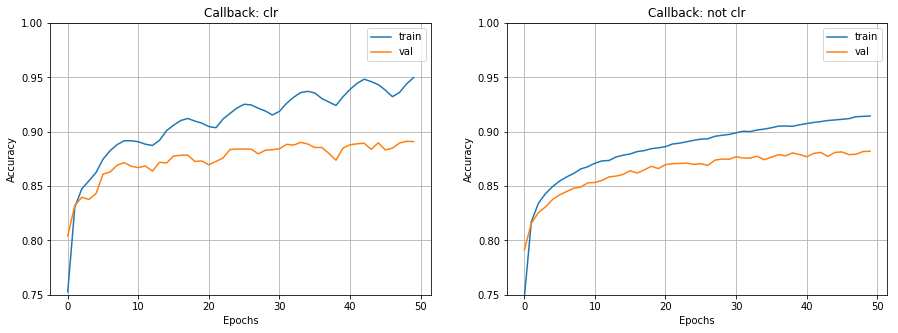

In [174]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, key in zip(axes, history.keys()):
    ax.plot(history[key].history["accuracy"], label="train")
    ax.plot(history[key].history["val_accuracy"], label="val")
    ax.legend()
    ax.set_ylim(0.75, 1.0)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title(f"Callback: {key}")
    ax.grid()

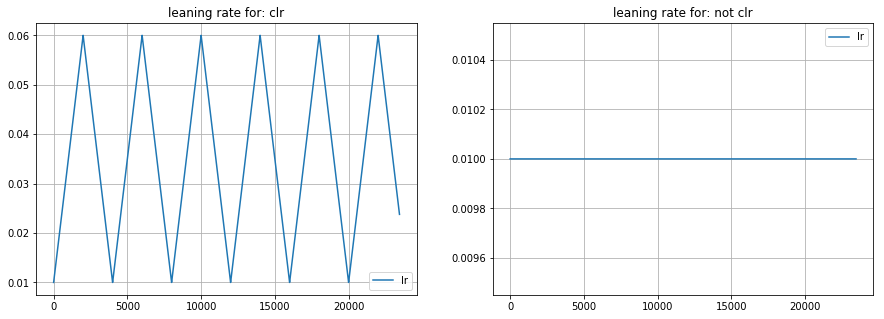

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for ax, key in zip(axes, callbacks.keys()):
    ax.plot(callbacks[key].history["clr"], label="lr")
    ax.legend()
    ax.set_title(f"leaning rate for: {key}")
    ax.grid()

# Сохранение нескольких моделей: snapshot ensembles

Ссылка на статью: [arxiv](https://arxiv.org/abs/1704.00109)

N моделей, обученных на одних данных независимо, обычно показывают меньшую склонность к переобучению и лучшие результаты на валидационной и тестовой выборках. Например, [Random Forest](https://en.wikipedia.org/wiki/Random_forest#Bagging) основан на таком подходе над решающими деревьями.

Идея snapshot ensembles следующая:

1. Дадим модели обучиться, скажем, до выхода на плато val loss. 
2. Выберем функцию для циклического изменения lr. Резко поднимем значение lr и будем снижать его до прежнего постепенно. В момент, когда lr дойдет до минимума, сохраним параметры модели и снова поднимем значение lr... и так N раз.
3. Составим из моделей ансамбль и используем его для прогнозирования. Используйте среднее по прогнозам моделей: `np.mean([model.predict(x) for model in models], axis=0)`

> У snapshot ebsembles есть недостатки: вместо одного набора весов вы используетете n наборов весов, что делает модель значительно более требовательной к ресурсам. А нейросеть - это далеко не решающее дерево по сложнсоти.  Тем не менее, когда важна точность, а не производительность (привет, kaggle!), такой подход часто себя оправдывает.

Для snapshot ensembles используется функция cosine annealing (annealing - отжиг):

> О́тжиг — вид термической обработки, заключающийся в нагреве до определённой температуры, выдержке в течение определенного времени при этой температуре и последующем, обычно медленном, охлаждении до комнатной температуры. При отжиге осуществляются процессы возврата (отдыха металлов), рекристаллизации и гомогенизации.  
Snapshot ensemles похожи на "отжиг" нейронной сети, где lr служит аналогом

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def cosine_annealing(epoch, n_epochs, n_cycles, lrate_max):
	epochs_per_cycle = np.floor(n_epochs / n_cycles)
	cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
	return lrate_max / 2 * (np.cos(cos_inner) + 1)

# График cosine annealing

> **Важно!** `n_epochs`, `n_cycles` - гиперпараметры и требуют подбора.

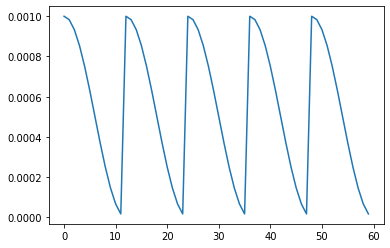

In [ ]:
n_epochs = 60
n_cycles = 5
lrate_max = 1e-3
series = [cosine_annealing(i, n_epochs, n_cycles, lrate_max)
          for i in range(n_epochs)]
pyplot.plot(series)
pyplot.show()

# Задание 2: Snapshot Ensemble Callback

* Реализуйте snapshot ensemble callback. Шаблон с инструкциями далее.
* Обучите нейронные сети с одинаковой архитектурой с `SnapshotEnsembleCallback` и без него. Посмотрите шаблон обучения нейросетей, прежде чем приступать к реализации коллбэка.
* Сравните качество одной модели и ансамбля моделей.

## Шаблон

**Важно!** Вы можете заменить работу с эпохами на работу с батчами. Т.е. `n_epochs -> n_batches`, `on_epoch_...` -> `on_batch_...`. Это может понадобиться, если нейросеть обучается "слишком быстро" по сравнению с изменениями lr. Нужна ли заменя, придется проверять экспериментально, ориентируясь на результаты валидации ансамбля моделей и графики обучения. Готового рецепта, как это понять, у меня нет.

In [ ]:
# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
  """ 
  Реализация Snapshot Ensemble.

  # Arguments
    n_epochs: полное количество эпох.
    n_cycles: количество циклов за заданное число эпох.
    lrate_max: максимальное значение lr ()

  """
  def __init__(self, n_epochs, n_cycles, lrate_max):   
    # Задайте параметры объекта
    ...

 
	# calculate learning rate for epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
    """ Был определен выше. Можете перенсти определение в метод 
    (тогда лучше сделать его @staticmethod)
    """
		return cosine_annealing(n_epochs, n_cycles, lrate_max)
 
	def on_epoch_begin(self, epoch, logs={}):
   """ В начале каждой эпохи обновляйте значение lr при помощи
   self.cosine_annealing и K.set_value. 
   Желательно так же сохранять значение lr в лог.
   """
   ...
 
	# save models at the end of each cycle
	def on_epoch_end(self, epoch, logs={}):
		""" Сохраняйте модель на тех эпохах, когда lr достиг минимума.
    Для сохранения используйте self.model.save(filename). В имени файла можно
    хранить информацию о номере эпохи, лоссе и т.д.
    """
    ...

## Обучение моделей

Создайте и обучите одну модель на датасете fashion mnist. Используйте `EarlyStoppingCallback`, чтобы избежать переобучения.

In [ ]:
def make_model(...):
  # Функция для создания модели
  ...

model = make_model(...)
model.compile(...)


model.fit(..., callbacls=[early_stopping])

Создайте _еще одну_ такую же модель и обучите ее с использованием `EarlyStoppingCallback`.

In [ ]:
def make_model(...):
  # Функция для создания модели
  ...

another_model = make_model(...)
another_model.compile(...)


another_model.fit(..., callbacls=[early_stopping])

**Продолжите обучение** второй модели c использованием `SnapshotEnsemple`. На этом шаге важно убедиться, что
* Модель сходится к близкому к "изначальному" значению минимума, метрики похожи
* Если это не так, нужно подобрать гиперпараметры (значения max lr, количество эпох, количество циклов) 

In [ ]:
another_model.fit(..., callbacls=[snaphot_ensemble])

Загрузите модели и сравните качество одной модели и ансамбля снапшотов (инструкция, как посчитать прогноз снапшота, была раньше). Сравнивайте значения val_loss, val_accuracy, train_loss, train_accuracy.  
> Можете провести несколько экспериментов для одних и тех де моделей и построить доверительные интервалы, как в прошлом д/з.  

# Ссылки

При подготовке д/з использовались
1. Пример с [github](https://github.com/bckenstler/CLR/blob/master/clr_callback.py)
2. [Туториал про ансамбли](https://machinelearningmastery.com/snapshot-ensemble-deep-learning-neural-network/)

В принципе, вы можете найти там нужный код, но призываю вас попробовать реализовать коллбеки самостоятельно.